In [3]:
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm

from matplotlib import pyplot as plt
SEED = 923984

# Activation function

In [4]:
from reservoir.activation_functions import tanh, heaviside, sigmoid

# activation_function = lambda x : sigmoid(2*(x-0.5))tanh(x)
activation_function = lambda x : tanh(x)

# Loading and Preprocessing

Lots of different on availabale : https://towardsdatascience.com/a-data-lakes-worth-of-audio-datasets-b45b88cd4ad

Regression : http://tseregression.org/ + https://arxiv.org/pdf/2012.02974

Prediction Datasets available :

* MackeyGlass
* Lorenz
* Sunspot

Classification Datasets available :

* Custom :  FSDD, HAART, JapaneseVowels
* Aeon : SpokenArabicDigits, CatsDogs, LSST
* Torchaudio: SPEECHCOMMANDS

More on https://www.timeseriesclassification.com/dataset.php or https://pytorch.org/audio/stable/datasets.html

In [5]:
import math
from scipy import sparse, stats
from datasets.load_forecasting import load_dataset_forecasting
from datasets.load_classification import load_dataset_classification

# Cross validation
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit, StratifiedGroupKFold
from datasets.preprocessing import flexible_indexing

#Preprocessing
from datasets.multivariate_generation import generate_multivariate_dataset, extract_peak_frequencies
from sklearn.preprocessing import MinMaxScaler
from datasets.preprocessing import scale_data
from datasets.preprocessing import add_noise, duplicate_data
from datasets.load_data import load_data as load_dataset

# Define noise parameter
noise_std = 0.001

data_type = "normal" # "normal" ou "noisy"

def load_data(dataset_name, data_type, noise_std, step_ahead=5, visualize=False):
    (is_instances_classification, is_multivariate, sampling_rate,
     X_train_raw, X_test_raw, Y_train_raw, Y_test,
     use_spectral_representation, spectral_representation,
     groups) = load_dataset(dataset_name, step_ahead, visualize=False)
    
    WINDOW_LENGTH = 10
    freq_train_data = X_train_raw
    flat_train_data = np.concatenate(freq_train_data, axis=0) if is_instances_classification else freq_train_data
    extract_peak_frequencies(flat_train_data, sampling_rate, smooth=True, window_length=WINDOW_LENGTH, threshold=1e-5, nperseg=1024, visualize=False)
    
    if is_multivariate:
        X_train_band, X_test_band = X_train_raw, X_test_raw
        del X_train_raw, X_test_raw
        X_val_band = None
    else:
        X_test, X_train = X_test_raw, X_train_raw
        X_val, X_val_band = None, None
        del X_train_raw, X_test_raw
    Y_train = Y_train_raw
    del Y_train_raw
            
    # PREPROCESSING    
    freq_train_data = X_train_band if is_multivariate else X_train
    flat_train_data = np.concatenate(freq_train_data, axis=0) if is_instances_classification else freq_train_data
    peak_freqs = extract_peak_frequencies(flat_train_data, sampling_rate, smooth=True, window_length=WINDOW_LENGTH, threshold=1e-5, nperseg=1024, visualize=False)
    
    
    if not is_multivariate:
        X_train_band = generate_multivariate_dataset(
            X_train, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
        )
        
        X_test_band = generate_multivariate_dataset(
            X_test, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
        )
    elif not use_spectral_representation:
        X_train_band = generate_multivariate_dataset(
            X_train_band, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
        )
        X_test_band = generate_multivariate_dataset(
            X_test_band, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
        )
    else:
        print("Data is already spectral and multivariate, nothing to do")
        
    scaler_multi = MinMaxScaler(feature_range=(0, 1))
    X_train_band, X_val_band, X_test_band = scale_data(X_train_band, X_val_band, X_test_band, scaler_multi, is_instances_classification)
                
    if not is_multivariate:
        scaler_x_uni = MinMaxScaler(feature_range=(0, 1))
        X_train, X_val, X_test = scale_data(X_train, X_val, X_test, scaler_multi, is_instances_classification)       
    
    # NOISE
    if data_type == "noisy":
        if is_instances_classification:
            # UNI
            if not is_multivariate:
                X_train_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_train, desc="TRAIN")]
                X_test_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_test, desc="TEST")]
                
            # MULTI
            X_train_band_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_train_band, desc="TRAIN")]
            X_test_band_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_test_band, desc="TEST")]
        
        else:  #if prediction
            # UNI
            if not is_multivariate:
                X_train_noisy = add_noise(X_train, noise_std)
                X_test_noisy = add_noise(X_test, noise_std)
        
            # MULTI
            X_train_band_noisy = add_noise(X_train_band, noise_std)
            X_test_band_noisy = add_noise(X_test_band, noise_std)
    
    # Define the number of instances you want to select
    # Define the number of instances you want to select
    x_size = len(X_train_band) if is_multivariate else len(X_train)
    num_samples_for_pretrain = 500 if x_size >= 500 else x_size
    if is_instances_classification:
        indices = np.random.choice(x_size, num_samples_for_pretrain, replace=False)
    else:
        indices = range(x_size)
    
    
    if data_type == "noisy":
        # Defining pretrain   
        if not is_multivariate:
            X_pretrain_noisy = np.array(X_train_noisy, dtype=object)[indices].flatten()
        X_pretrain_band_noisy = np.array(X_train_band_noisy, dtype=object)[indices]
    
    if not is_multivariate:
        X_pretrain = np.array(X_train, dtype=object)[indices].flatten()
    X_pretrain_band = np.array(X_train_band, dtype=object)[indices]

    return X_pretrain_band, X_train_band, X_test_band, Y_train, Y_test, is_multivariate, is_instances_classification

# Evaluation function

In [6]:
from scipy import stats
from numpy import random
import os


# Evaluating
from performances.esn_model_evaluation import train_model_for_classification, predict_model_for_classification, compute_score
from performances.esn_model_evaluation import (train_model_for_prediction, init_reservoir, init_ip_reservoir, init_local_rule_reservoir, 
                                                init_ip_local_rule_reservoir, init_readout)
from analysis.richness import spectral_radius, pearson, squared_uncoupled_dynamics_alternative, condition_number
from reservoir.reservoir import init_matrices
from connexion_generation.hag import run_algorithm

nb_jobs = 10
def evaluate_dataset_on_test(study, dataset_name, function_name, pretrain_data, train_data, test_data, Y_train, Y_test, is_instances_classification, nb_trials = 8, record_metrics=False):
    # Collect all hyperparameters in a dictionary
    hyperparams = {param_name: param_value for param_name, param_value in study.best_trial.params.items()}
    print(hyperparams)
    leaky_rate = 1
    input_connectivity = 1

    # score for prediction
    if dataset_name == "Sunspot":
        start_step = 30
        end_step = 500
    else:
        start_step = 500
        end_step = 1500
    SLICE_RANGE = slice(start_step, end_step)

    if 'variance_target' not in hyperparams and 'min_variance' in hyperparams:
        hyperparams['variance_target'] = hyperparams['min_variance']
    if not is_instances_classification:
        hyperparams['use_full_instance'] = False

    RIDGE_COEF = 10**hyperparams['ridge']
    
    if function_name in ["hadsp", "desp"]:
        MAX_TIME_INCREMENT = hyperparams['time_increment'] + hyperparams['time_increment_span'] #int(max_window_size) or None or TIME_INCREMENT
    
    scores = [] 
    if record_metrics:
        spectral_radii = []
        pearson_correlations = []
        CEVs = []
        CNs = []
    for i in range(nb_trials):
        common_index = 1
        if is_instances_classification:
            common_size = pretrain_data[0].shape[common_index]
        else:
            common_size = pretrain_data.shape[common_index]

        # We want the size of the reservoir to be at least network_size
        K = math.ceil(hyperparams['network_size'] / common_size)
        n = common_size * K
    
        # UNSUPERVISED PRETRAINING 
        if function_name == "random_ei":
            Win, W, bias = init_matrices(n, input_connectivity, hyperparams['connectivity'],  K, w_distribution=stats.uniform(-1, 1), seed=random.randint(0, 1000))
        else:
            Win, W, bias = init_matrices(n, input_connectivity, hyperparams['connectivity'] ,  K, seed=random.randint(0, 1000))
        bias *= hyperparams['bias_scaling']
        Win *= hyperparams['input_scaling']

        if function_name == "hadsp":
            W, (_, _, _) = run_algorithm(W, Win, bias, hyperparams['leaky_rate'], activation_function, pretrain_data, hyperparams['time_increment'], hyperparams['weight_increment'],
                                     hyperparams['target_rate'], hyperparams['rate_spread'], function_name, is_instance=is_instances_classification, use_full_instance=hyperparams['use_full_instance'],
                                     max_increment=MAX_TIME_INCREMENT, max_partners=hyperparams['max_partners'], method=hyperparams['method'], n_jobs=nb_jobs)
        elif function_name == "desp":
            W, (_, _, _) = run_algorithm(W, Win, bias, hyperparams['leaky_rate'], activation_function, pretrain_data, hyperparams['time_increment'], hyperparams['weight_increment'],
                                    hyperparams['variance_target'], hyperparams['variance_spread'], function_name, is_instance=is_instances_classification, 
                                    use_full_instance = hyperparams['use_full_instance'], max_increment=MAX_TIME_INCREMENT, max_partners=hyperparams['max_partners'], method = hyperparams['method'], 
                                    intrinsic_saturation=hyperparams['intrinsic_saturation'], intrinsic_coef=hyperparams['intrinsic_coef'], n_jobs = nb_jobs)
        elif function_name in ["random", "random_ei", "ip_correct", "anti-oja", "ip-anti-oja"]:
            eigen = sparse.linalg.eigs(W, k=1, which="LM", maxiter=W.shape[0] * 20, tol=0.1, return_eigenvectors=False)
            W *= hyperparams['spectral_radius'] / max(abs(eigen))
        else:
            raise ValueError(f"Invalid function: {function_name}")
        
        # unsupervised local rules
        if is_instances_classification:
            unsupervised_pretrain = np.concatenate(pretrain_data).astype(float)
        else:
            unsupervised_pretrain = pretrain_data.astype(float)
        if function_name == "ip_correct":
            reservoir = init_ip_reservoir(W, Win, bias, mu=hyperparams['mu'], sigma=hyperparams['sigma'], learning_rate=hyperparams['learning_rate'],
                                          leaking_rate=hyperparams['leaky_rate'], activation_function=activation_function
                                          )
            _ = reservoir.fit(unsupervised_pretrain, warmup=100)
        elif function_name == "anti_oja":
            reservoir = init_local_rule_reservoir(W, Win, bias, local_rule="anti-oja", eta=hyperparams['oja_eta'],
                                                   synapse_normalization=True, bcm_theta=None,
                                                   leaking_rate=hyperparams['leaky_rate'], activation_function=activation_function,
                                                   )
            _ = reservoir.fit(unsupervised_pretrain, warmup=100)
        elif function_name == "ip-anti-oja":
            reservoir = init_ip_local_rule_reservoir(W, Win, bias, local_rule="anti-oja", eta=hyperparams['oja_eta'],
                                                      synapse_normalization=True, bcm_theta=None,
                                                      mu=hyperparams['mu'], sigma=hyperparams['sigma'], learning_rate=hyperparams['learning_rate'],
                                                      leaking_rate=hyperparams['leaky_rate'], activation_function=activation_function,
                                                      )
            _ = reservoir.fit(unsupervised_pretrain, warmup=100)
        else:
            reservoir = init_reservoir(W, Win, bias, leaky_rate, activation_function)
        readout = init_readout(ridge_coef=RIDGE_COEF)

        
        # TRAINING and EVALUATION
        if is_instances_classification:
            mode = "sequence-to-vector"
            train_model_for_classification(reservoir, readout, train_data, Y_train, n_jobs = nb_jobs, mode=mode)

            Y_pred = predict_model_for_classification(reservoir, readout, test_data, n_jobs = nb_jobs, mode=mode)
            score = compute_score(Y_pred, Y_test, is_instances_classification)
        else:
            esn = train_model_for_prediction(reservoir, readout, train_data, Y_train, warmup=start_step)
            
            Y_pred =  esn.run(test_data, reset=False)
            score = compute_score(Y_pred[SLICE_RANGE], Y_test[SLICE_RANGE], is_instances_classification)

        scores.append(score)
        if record_metrics:
            states_history_multi = []
            neurons_state = np.random.uniform(0, 1, bias.size)
            inputs = np.concatenate(test_data, axis=0) if is_instances_classification else test_data
            states_history_multi = reservoir.run(inputs)
            
            sr = spectral_radius(W)
            pearson_correlation, _ = pearson(states_history_multi, num_windows=1, size_window=len(states_history_multi), step_size = 1, show_progress=True)
            CEV = squared_uncoupled_dynamics_alternative(states_history_multi, num_windows=1, size_window=len(states_history_multi), step_size = 1, show_progress=True)

            spectral_radii.append(sr)
            pearson_correlations.append(pearson_correlation[0])
            CEVs.append(CEV[0])
            #CNs.append(CN[0])

    if record_metrics:
        return scores, spectral_radii, pearson_correlations, CEVs
    return scores


# Test scores

In [7]:
import numpy as np
import pandas as pd
from datetime import datetime

from performances.utility import retrieve_best_model

# Create an empty DataFrame to store the results
columns = ['Dataset', 'Function', 'Average Score', 'Standard Deviation', 'Date']
variate_type = "multi"  # "multi" or "uni"

for dataset_name in ["MackeyGlass", "Lorenz", "Sunspot", "Henon", "NARMA"]: 
    new_results = pd.DataFrame(columns=columns)
    # Can be "MackeyGlass", "Lorenz", "Sunspot", "Henon", "NARMA", "CatsDogs", "FSDD", "JapaneseVowels", "SPEECHCOMMANDS", "SpokenArabicDigits", "Henon"
    pretrain_data, train_data, test_data, Y_train, Y_test, is_multivariate, is_instances_classification = load_data(dataset_name, data_type, noise_std, visualize=True)
    if is_instances_classification:
        file_name = "outputs/test_results_classification.csv"
    else: 
        file_name = "outputs/test_results_prediction.csv"
    print(dataset_name)
    # Simulate your data and loop for evaluation

    for function_name in ["desp", "hadsp", "ip-anti-oja", "anti-oja", "ip_correct", "random", "random_ei"]: # "desp", "hadsp", "ip-anti-oja", "anti-oja", "ip_correct", "random", "random_ei"
        print(function_name)
        study = retrieve_best_model(function_name, dataset_name, is_multivariate, variate_type = "multi", data_type = "normal")
    
        scores = evaluate_dataset_on_test(
            study, 
            dataset_name,
            function_name, 
            pretrain_data, 
            train_data, 
            test_data,
            Y_train, 
            Y_test,
            is_instances_classification,
            record_metrics=False
        )
        # Compute the average and standard deviation of the scores
        average_score = np.mean(scores)
        std_deviation = np.std(scores)
    
        if is_instances_classification:
            formatted_average = f"{round(average_score * 100, 5)} %"
            formatted_std = f"± {round(std_deviation * 100, 5)} %"
        else:
            formatted_average = f"{round(average_score, 5)}"
            formatted_std = f"± {round(std_deviation, 5)}"
        
        # Capture the current date
        current_date = datetime.now().strftime('%Y-%m-%d')
        
        # Create a new DataFrame row with the Date column
        new_row = pd.DataFrame({
            'Dataset': [dataset_name],
            'Function': [function_name],
            'Average Score': [formatted_average],
            'Standard Deviation': [formatted_std],
            'Date': [current_date]
        })
        
        # Concatenate the new row to the results DataFrame
        new_results = pd.concat([new_results, new_row], ignore_index=True)
    
    
    # Display the DataFrame
    print(new_results)
    
    # Load the existing CSV
    if os.path.exists(file_name):
        previous_results = pd.read_csv(file_name)
    else:
        columns = ['Dataset', 'Function', 'Average Score', 'Standard Deviation', 'Date']
        previous_results = pd.DataFrame(columns=columns)
        previous_results.to_csv(file_name, index=False)
        print(f"{file_name} created successfully.")
        
    tots_results = pd.concat([new_results, previous_results], axis=0)
    
    tots_results.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}.")

MackeyGlass
desp
{'ridge': -12, 'network_size': 500, 'input_scaling': 0.060000000000000005, 'bias_scaling': 0.03, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'variance_target': 0.016, 'variance_spread': 0.003, 'intrinsic_saturation': 0.8200000000000001, 'intrinsic_coef': 0.88, 'method': 'pearson', 'connectivity': 0.0, 'weight_increment': 0.082, 'max_partners': 16, 'time_increment': 32, 'time_increment_span': 48}


HAG algorithm: 100%|██████████████████████████████████████████████████▊| 14773/14840 [01:02<00:00, 237.87it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.10058e-20): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
HAG algorithm:  99%|██████████████████████████████████████████████████▋| 14763/14840 [00:59<00:00, 248.87it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.19924e-20): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
HAG algorithm: 100%|██████████████████████████████████████████████████▉| 14806/14840 [01:00<00:00, 246.01it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Il

hadsp
{'ridge': -11, 'network_size': 500, 'input_scaling': 0.19, 'bias_scaling': 0.04, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'target_rate': 0.52, 'rate_spread': 0.37, 'method': 'pearson', 'connectivity': 0.0, 'weight_increment': 0.056, 'max_partners': 17, 'time_increment': 23, 'time_increment_span': 31}


HAG algorithm: 100%|█████████████████████████████████████████████████▉| 14853/14885 [00:07<00:00, 1990.28it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=5.80366e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
HAG algorithm: 100%|█████████████████████████████████████████████████▊| 14843/14885 [00:07<00:00, 2111.31it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.97241e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
HAG algorithm: 100%|█████████████████████████████████████████████████▊| 14843/14885 [00:07<00:00, 1969.43it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Il

ip-anti-oja
{'ridge': -12, 'network_size': 500, 'input_scaling': 0.11, 'bias_scaling': 0.155, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.012126692182744415, 'spectral_radius': 0.7, 'mu': 0.009493678275587909, 'sigma': 0.09342259700794674, 'learning_rate': 0.005721887047361266, 'oja_eta': 0.0006929377319273062}


/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.1847e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.28913e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.96815e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.10848e-17): result may not be accurate.

anti-oja
{'ridge': -12, 'network_size': 500, 'input_scaling': 0.045000000000000005, 'bias_scaling': 0.11, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.006001086237736066, 'spectral_radius': 0.9400000000000001, 'oja_eta': 0.00010226077303733307}


/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.56308e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.45127e-20): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=7.71975e-20): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.2391e-20): result may not be accurate.

ip_correct
{'ridge': -11, 'network_size': 500, 'input_scaling': 0.09, 'bias_scaling': 0.085, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.0056427910498423, 'spectral_radius': 0.8300000000000001, 'mu': 0.3854531010041829, 'sigma': 0.911966126808139, 'learning_rate': 2.3585489751791736e-06}


/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.21744e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.83285e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.90897e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.06321e-18): result may not be accurate

random
{'ridge': -12, 'network_size': 500, 'input_scaling': 0.045000000000000005, 'bias_scaling': 0.2, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.003190956687031515, 'spectral_radius': 0.89}


/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.50201e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.49691e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.22861e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.07944e-19): result may not be accurate

random_ei
{'ridge': -12, 'network_size': 500, 'input_scaling': 0.15000000000000002, 'bias_scaling': 0.16, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.005747915649110966, 'spectral_radius': 0.99}


/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.74753e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.40661e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.41069e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.37944e-18): result may not be accurate

       Dataset     Function Average Score Standard Deviation        Date
0  MackeyGlass         desp       0.01054          ± 0.00868  2025-02-25
1  MackeyGlass        hadsp       0.00525          ± 0.00019  2025-02-25
2  MackeyGlass  ip-anti-oja       0.00445           ± 0.0006  2025-02-25
3  MackeyGlass     anti-oja       0.00516          ± 0.00022  2025-02-25
4  MackeyGlass   ip_correct       0.00562          ± 0.00024  2025-02-25
5  MackeyGlass       random       0.00575          ± 0.00038  2025-02-25
6  MackeyGlass    random_ei       0.00587           ± 0.0004  2025-02-25
Results saved to outputs/test_results_prediction.csv.


/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `seed`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


Lorenz
desp
{'ridge': -12, 'network_size': 500, 'input_scaling': 0.060000000000000005, 'bias_scaling': 0.03, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'variance_target': 0.010000000000000002, 'variance_spread': 0.005, 'intrinsic_saturation': 0.8400000000000001, 'intrinsic_coef': 0.9600000000000001, 'method': 'pearson', 'connectivity': 0.0, 'weight_increment': 0.09, 'max_partners': 20, 'time_increment': 100, 'time_increment_span': 22}


HAG algorithm: 100%|██████████████████████████████████████████████████▉| 14473/14500 [00:26<00:00, 548.52it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.7278e-21): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
HAG algorithm: 100%|██████████████████████████████████████████████████▊| 14431/14500 [00:25<00:00, 562.77it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=6.47784e-21): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
HAG algorithm:  99%|██████████████████████████████████████████████████▋| 14395/14500 [00:26<00:00, 549.10it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill

hadsp
{'ridge': -12, 'network_size': 500, 'input_scaling': 0.04, 'bias_scaling': 0.14, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'target_rate': 0.5, 'rate_spread': 0.385, 'method': 'pearson', 'connectivity': 0.0, 'weight_increment': 0.049, 'max_partners': 19, 'time_increment': 84, 'time_increment_span': 40}


HAG algorithm: 100%|█████████████████████████████████████████████████▉| 14549/14580 [00:07<00:00, 2004.20it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.17558e-21): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
HAG algorithm:  99%|█████████████████████████████████████████████████▋| 14488/14580 [00:06<00:00, 2097.62it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.7414e-21): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
HAG algorithm: 100%|█████████████████████████████████████████████████▊| 14523/14580 [00:07<00:00, 1949.15it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill

ip-anti-oja
{'ridge': -7, 'network_size': 500, 'input_scaling': 0.015, 'bias_scaling': 0.17, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.16423338921243097, 'spectral_radius': 0.75, 'mu': 0.3757123646898425, 'sigma': 0.18915837261499402, 'learning_rate': 3.6155532419989744e-06, 'oja_eta': 1.00591371523536e-05}
anti-oja
{'ridge': -11, 'network_size': 500, 'input_scaling': 0.025, 'bias_scaling': 0.025, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.0026739626382449814, 'spectral_radius': 0.81, 'oja_eta': 0.0001562290434123027}


/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.0553e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=6.75705e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.19878e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.00076e-17): result may not be accurate.

ip_correct
{'ridge': -11, 'network_size': 500, 'input_scaling': 0.01, 'bias_scaling': 0.095, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.004176286707487459, 'spectral_radius': 1.34, 'mu': 0.22369003422066272, 'sigma': 0.3742044382072255, 'learning_rate': 0.00023415372989597655}


/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.36836e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.82023e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.65703e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.15114e-18): result may not be accurate

random
{'ridge': -11, 'network_size': 500, 'input_scaling': 0.01, 'bias_scaling': 0.09, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.00297956957774137, 'spectral_radius': 0.75}


/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=5.25933e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.44104e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.29808e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=6.30036e-18): result may not be accurate

random_ei
{'ridge': -9, 'network_size': 500, 'input_scaling': 0.05, 'bias_scaling': 0.19, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.0026574563838450416, 'spectral_radius': 0.64}
  Dataset     Function Average Score Standard Deviation        Date
0  Lorenz         desp       0.06058          ± 0.00642  2025-02-25
1  Lorenz        hadsp       0.19435           ± 0.1244  2025-02-25
2  Lorenz  ip-anti-oja       0.10391          ± 0.01322  2025-02-25
3  Lorenz     anti-oja       0.09882          ± 0.00416  2025-02-25
4  Lorenz   ip_correct       0.10096           ± 0.0124  2025-02-25
5  Lorenz       random       0.09769           ± 0.0029  2025-02-25
6  Lorenz    random_ei       0.10925          ± 0.00454  2025-02-25
Results saved to outputs/test_results_prediction.csv.
Sunspot
desp
{'ridge': -12, 'network_size': 500, 'input_scaling': 0.045000000000000005, 'bias_scaling': 0.135, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'variance_target': 0.008, 'variance_spread': 

HAG algorithm:  99%|████████████████████████████████████████████████████▎| 2774/2809 [00:11<00:00, 245.50it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.78787e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
HAG algorithm:  98%|███████████████████████████████████████████████████▊ | 2746/2809 [00:11<00:00, 232.91it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.03234e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
HAG algorithm:  99%|████████████████████████████████████████████████████▏| 2768/2809 [00:11<00:00, 244.40it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Il

hadsp
{'ridge': -12, 'network_size': 500, 'input_scaling': 0.025, 'bias_scaling': 0.145, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'target_rate': 0.51, 'rate_spread': 0.395, 'method': 'pearson', 'connectivity': 0.0, 'weight_increment': 0.096, 'max_partners': 11, 'time_increment': 47, 'time_increment_span': 24}


HAG algorithm:  99%|████████████████████████████████████████████████████▌| 2704/2729 [00:03<00:00, 801.89it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.30039e-20): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
HAG algorithm:  99%|████████████████████████████████████████████████████▋| 2713/2729 [00:03<00:00, 856.65it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.1458e-19): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
HAG algorithm:  99%|████████████████████████████████████████████████████▍| 2700/2729 [00:03<00:00, 763.56it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill

ip-anti-oja
{'ridge': -9, 'network_size': 500, 'input_scaling': 0.02, 'bias_scaling': 0.0, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.1990102154806574, 'spectral_radius': 0.98, 'mu': 0.018381901370504036, 'sigma': 0.021745478982360712, 'learning_rate': 2.2266595370840583e-05, 'oja_eta': 0.0007049917186603863}
anti-oja
{'ridge': -11, 'network_size': 500, 'input_scaling': 0.03, 'bias_scaling': 0.1, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.003341930011729736, 'spectral_radius': 0.5900000000000001, 'oja_eta': 1.0096670951063993e-05}


/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.70592e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.27014e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.91536e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.24669e-17): result may not be accurate

ip_correct
{'ridge': -10, 'network_size': 500, 'input_scaling': 0.03, 'bias_scaling': 0.035, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.0033775312084427973, 'spectral_radius': 0.8500000000000001, 'mu': 0.00781547165287888, 'sigma': 0.7994821172368859, 'learning_rate': 1.822236997888863e-05}
random
{'ridge': -12, 'network_size': 500, 'input_scaling': 0.015, 'bias_scaling': 0.0, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.0037597669643489994, 'spectral_radius': 0.71}


/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.2107e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.19123e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.28006e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.58925e-18): result may not be accurate.

random_ei
{'ridge': -10, 'network_size': 500, 'input_scaling': 0.065, 'bias_scaling': 0.17, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.004175356406565916, 'spectral_radius': 0.91}
   Dataset     Function Average Score Standard Deviation        Date
0  Sunspot         desp       0.01206          ± 0.01103  2025-02-25
1  Sunspot        hadsp       0.01657          ± 0.01245  2025-02-25
2  Sunspot  ip-anti-oja       0.00343          ± 0.00079  2025-02-25
3  Sunspot     anti-oja       0.00452          ± 0.00038  2025-02-25
4  Sunspot   ip_correct       0.00409          ± 0.00026  2025-02-25
5  Sunspot       random       0.00261          ± 0.00017  2025-02-25
6  Sunspot    random_ei         0.003          ± 0.00025  2025-02-25
Results saved to outputs/test_results_prediction.csv.
Henon
desp
{'ridge': -7, 'network_size': 500, 'input_scaling': 0.01, 'bias_scaling': 0.0, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'variance_target': 0.003, 'variance_spread': 0.001, 'intr

HAG algorithm: 100%|██████████████████████████████████████████████████▋| 14607/14680 [00:49<00:00, 294.27it/s]


hadsp
{'ridge': -6, 'network_size': 500, 'input_scaling': 0.04, 'bias_scaling': 0.14, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'target_rate': 0.53, 'rate_spread': 0.37, 'method': 'pearson', 'connectivity': 0.0, 'weight_increment': 0.012, 'max_partners': 10, 'time_increment': 29, 'time_increment_span': 14}


HAG algorithm: 100%|██████████████████████████████████████████████████▉| 14829/14855 [00:34<00:00, 426.65it/s]


ip-anti-oja
{'ridge': -5, 'network_size': 500, 'input_scaling': 0.025, 'bias_scaling': 0.08, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.14251492351002942, 'spectral_radius': 0.81, 'mu': 0.3113194139189528, 'sigma': 0.09946833204456351, 'learning_rate': 1.0107152298672118e-06, 'oja_eta': 5.741552311623483e-05}
anti-oja
{'ridge': -5, 'network_size': 500, 'input_scaling': 0.02, 'bias_scaling': 0.07, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.0026113700692383867, 'spectral_radius': 0.99, 'oja_eta': 2.4633775843527392e-05}
ip_correct
{'ridge': -8, 'network_size': 500, 'input_scaling': 0.01, 'bias_scaling': 0.025, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.05952584657173143, 'spectral_radius': 1.27, 'mu': 0.9168548091281423, 'sigma': 0.7457735404116079, 'learning_rate': 1.8806275504580957e-05}
random
{'ridge': -5, 'network_size': 500, 'input_scaling': 0.03, 'bias_scaling': 0.055, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'con

HAG algorithm: 100%|██████████████████████████████████████████████████▊| 14922/14985 [02:02<00:00, 122.16it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.31159e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
HAG algorithm: 100%|██████████████████████████████████████████████████▊| 14925/14985 [01:58<00:00, 125.47it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=5.08795e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
HAG algorithm: 100%|██████████████████████████████████████████████████▉| 14978/14985 [01:59<00:00, 124.88it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Il

hadsp
{'ridge': -9, 'network_size': 500, 'input_scaling': 0.015, 'bias_scaling': 0.165, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'target_rate': 0.69, 'rate_spread': 0.35500000000000004, 'method': 'pearson', 'connectivity': 0.0, 'weight_increment': 0.016, 'max_partners': 14, 'time_increment': 76, 'time_increment_span': 69}


HAG algorithm: 100%|██████████████████████████████████████████████████▊| 14549/14620 [00:25<00:00, 580.45it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=6.12388e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
HAG algorithm:  99%|██████████████████████████████████████████████████▌| 14504/14620 [00:24<00:00, 585.35it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=7.4591e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
HAG algorithm: 100%|██████████████████████████████████████████████████▊| 14556/14620 [00:24<00:00, 585.08it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill

ip-anti-oja
{'ridge': -8, 'network_size': 500, 'input_scaling': 0.135, 'bias_scaling': 0.17, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.23174146653192657, 'spectral_radius': 1.5, 'mu': 0.19521414572312903, 'sigma': 0.6048664593302767, 'learning_rate': 0.0034877093580397414, 'oja_eta': 0.039960995053305456}
anti-oja
{'ridge': -10, 'network_size': 500, 'input_scaling': 0.01, 'bias_scaling': 0.0, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.0027905407578753174, 'spectral_radius': 0.89, 'oja_eta': 0.00012525618706437164}
ip_correct
{'ridge': -8, 'network_size': 500, 'input_scaling': 0.045000000000000005, 'bias_scaling': 0.18, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.003703981093715513, 'spectral_radius': 0.88, 'mu': 0.0001360301289493309, 'sigma': 0.04032362908915593, 'learning_rate': 1.4145606648940257e-06}
random
{'ridge': -12, 'network_size': 500, 'input_scaling': 0.01, 'bias_scaling': 0.02, 'leaky_rate': 1.0, 'input_connect

/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.14151e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.92594e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.45425e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.75874e-18): result may not be accurate

random_ei
{'ridge': -10, 'network_size': 500, 'input_scaling': 0.015, 'bias_scaling': 0.09, 'leaky_rate': 1.0, 'input_connectivity': 1.0, 'connectivity': 0.00637776089376208, 'spectral_radius': 0.9600000000000001}
  Dataset     Function Average Score Standard Deviation        Date
0   NARMA         desp       0.56662          ± 0.11822  2025-02-25
1   NARMA        hadsp       0.54302          ± 0.01691  2025-02-26
2   NARMA  ip-anti-oja       1.27224           ± 0.0042  2025-02-26
3   NARMA     anti-oja       0.52072          ± 0.05223  2025-02-26
4   NARMA   ip_correct       0.50896          ± 0.03764  2025-02-26
5   NARMA       random       0.52959          ± 0.05652  2025-02-26
6   NARMA    random_ei       0.58952          ± 0.05135  2025-02-26
Results saved to outputs/test_results_prediction.csv.


## Visualisation

In [8]:
import os
import pandas as pd 

if 'file_name' not in locals() and 'file_name' not in globals():
    file_name = "outputs/test_results_prediction.csv"  #  test_results_classification.csv or test_results_prediction.csv

if os.path.exists(file_name):
    previous_results = pd.read_csv(file_name)
else:
    # File does not exist, create it with the necessary columns
    columns = ['Dataset', 'Function', 'Average Score', 'Standard Deviation', 'Date']
    previous_results = pd.DataFrame(columns=columns)
    # Save the empty DataFrame as a CSV
    previous_results.to_csv(file_name, index=False)
    print(f"{file_name} created successfully.")

print(f"Results saved to {file_name}.")
previous_results

Results saved to outputs/test_results_prediction.csv.


,Dataset,Function,Average Score,Standard Deviation,Date
0,NARMA,desp,0.56662,± 0.11822,2025-02-25
1,NARMA,hadsp,0.54302,± 0.01691,2025-02-26
2,NARMA,ip-anti-oja,1.27224,± 0.0042,2025-02-26
3,NARMA,anti-oja,0.52072,± 0.05223,2025-02-26
4,NARMA,ip_correct,0.50896,± 0.03764,2025-02-26
5,NARMA,random,0.52959,± 0.05652,2025-02-26
6,NARMA,random_ei,0.58952,± 0.05135,2025-02-26
7,Henon,desp,0.31229,± 0.00164,2025-02-25
8,Henon,hadsp,0.31436,± 0.00102,2025-02-25
9,Henon,ip-anti-oja,0.66712,± 0.33186,2025-02-25


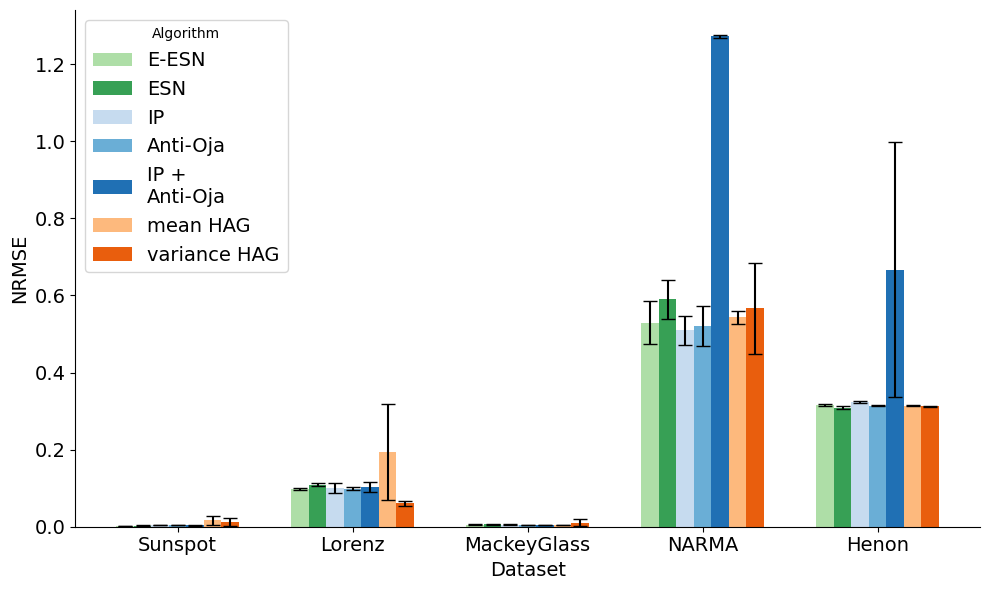

In [18]:
import pandas as pd
from seaborn import color_palette
from matplotlib import pyplot as plt
import numpy as np

all_results = pd.read_csv(file_name)
df = pd.DataFrame(all_results)

# Clean data as before
df['Average Score'] = df['Average Score'].astype(str).str.replace('%', '').astype(float)
df['Standard Deviation'] = df['Standard Deviation'].str.replace('±', '').str.replace('%', '').astype(float)

df = df[df['Function'] != 'ip']

df['Function'] = df['Function'].str.replace('ip-anti-oja', 'IP +\nAnti-Oja')
df['Function'] = df['Function'].str.replace('ip_correct', 'IP')
df['Function'] = df['Function'].str.replace('anti-oja', 'Anti-Oja')

df['Function'] = df['Function'].str.replace('desp', 'variance HAG')
df['Function'] = df['Function'].str.replace('hadsp', 'mean HAG')
df['Function'] = df['Function'].str.replace('random_ei', 'ESN')
df['Function'] = df['Function'].str.replace('random', 'E-ESN')

# Optional replacements for dataset names
if file_name == "outputs/test_results_classification.csv":
    df['Dataset'] = df['Dataset'].str.replace('SpokenArabicDigits', 'Spoken\nArabic\nDigits')
    df['Dataset'] = df['Dataset'].str.replace('SPEECHCOMMANDS', 'SPEECH\nCOMMANDS')
    df['Dataset'] = df['Dataset'].str.replace('JapaneseVowels', 'Japanese\nVowels')

# -- Define color palettes for each group --
blues = color_palette("Blues", 3)      # 3 shades of blue
oranges = color_palette("Oranges", 2)  # 2 shades of orange
greens = color_palette("Greens", 2)    # 2 shades of green

# -- Map each function to its color --
function_colors = {
    'E-ESN':              greens[0],
    'ESN':                greens[1],
    'IP':                 blues[0],
    'Anti-Oja':           blues[1],
    'IP +\nAnti-Oja':     blues[2],
    'mean HAG':           oranges[0],
    'variance HAG':       oranges[1],
}

# If you want a specific order for the bars, you can enforce it:
functions_order = [
    'E-ESN',
    'ESN', 
    'IP', 
    'Anti-Oja', 
    'IP +\nAnti-Oja', 
    'mean HAG', 
    'variance HAG', 
]

# Filter out (or keep) only the functions actually present in df
functions = [f for f in functions_order if f in df['Function'].unique()]

fig, ax = plt.subplots(figsize=(10, 6))

datasets = df['Dataset'].unique()
x = np.arange(len(datasets))  # The label locations
width = 0.1                  # Width of each bar

for i, func in enumerate(functions):
    # Grab only rows for this function
    values = df[df['Function'] == func]
    
    # Make sure the order of the 'Dataset' matches x in ascending order
    # so that bar positions align with x-ticks
    # One way: sort or reindex by the unique dataset order
    # We create a Series in the same order as 'datasets'
    merged = pd.DataFrame({'Dataset': datasets}).merge(values, on='Dataset', how='left')
    
    ax.bar(
        x + i * width,
        merged['Average Score'],
        width,
        label=func,
        yerr=merged['Standard Deviation'],
        capsize=5,
        color=function_colors[func]
    )



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)

fontsize = 14
ax.set_xlabel('Dataset', size=fontsize)
if file_name == "outputs/test_results_prediction.csv":
    plt.ylabel('NRMSE', size=fontsize)
else:
    plt.ylabel('Classification Rate', size=fontsize)
plt.legend(title='Algorithm', fontsize=fontsize)

# Position x-ticks in the center of all the bars for each dataset
ax.set_xticks(x + width * (len(functions)-1)/2)
ax.set_xticklabels(datasets)

plt.tight_layout()
plt.show()

# Best parameters

In [10]:
import os
import optuna
import pandas as pd
from performances.utility import camel_to_snake, retrieve_best_model


# List of datasets (extract from filenames)
datasets = [
    "SpokenArabicDigits",
    "JapaneseVowels",
    "FSDD",
    "SPEECHCOMMANDS",
    "CatsDogs",
    "MackeyGlass",
    "Lorenz",
    "Sunspot",
]

# Initialize an empty list to store results
results = []

# Initialize an empty list to store results
results = []
function_name = "ip"
for dataset in datasets:
    study = retrieve_best_model(function_name, dataset, is_multivariate=True, variate_type = "multi", data_type = "normal")
    best_trial = study.best_trial
    results.append({
        "dataset": dataset,
        "function_name": function_name,
        **best_trial.params,
    })
# Convert results to a DataFrame
df = pd.DataFrame(results)

# Save to CSV
df.to_csv(f"best_hyperparameters_{function_name}.csv", index=False)

print(f"Results saved to best_hyperparameters_{function_name}.csv")


ValueError: Invalid function name: ip

# Plot final values

In [ ]:
import os
import optuna
import pandas as pd
from performances.utility import camel_to_snake, retrieve_best_model

# Create an empty DataFrame to store the results
columns = [
    "dataset", 
    "function_name", 
    "spectral_radius_mean", 
    "spectral_radius_std", 
    "pearson_mean", 
    "pearson_std", 6-9
    "CEV_mean",
    "CEV_std",
    "scores_mean",
    "scores_std",
]

new_results = pd.DataFrame(columns=columns)

# List of datasets (extract from filenames)
datasets = [
    "CatsDogs",
    "JapaneseVowels",
    "SpokenArabicDigits",
    "FSDD",
#    "SPEECHCOMMANDS",
    "MackeyGlass",
    "Lorenz",
    "Sunspot",
]



# Initialize an empty list to store results
results = []

for dataset in datasets:
    print(dataset)
    pretrain_data, train_data, test_data, Y_train, Y_test, is_multivariate, is_instances_classification = load_data(dataset, data_type, noise_std)
    for function_name in ["random", "random_ei", "ip_correct", "hadsp", "desp", "anti-oja", "ip-anti-oja"]:
        # Get the best trial from the study
        print(function_name)
        study = retrieve_best_model(function_name, dataset, is_multivariate, variate_type = "multi", data_type = "normal")
        
        scores, SRs, pearsons, CEVs = evaluate_dataset_on_test(
            study, 
            function_name, 
            pretrain_data, 
            train_data, 
            test_data,
            Y_train, 
            Y_test,
            is_instances_classification,
            nb_trials = 4,
            record_metrics=True
        )
        print(scores)
        # Create a new DataFrame row
        new_row = pd.DataFrame({
            "dataset": [dataset],
            "function_name": [function_name],
            "spectral_radius_mean": [np.mean(SRs)],
            "spectral_radius_std": [np.std(SRs)],
            "pearson_mean": [np.mean(pearsons)],
            "pearson_std": [np.std(pearsons)],
            "CEV_mean": [np.mean(CEVs)],
            "CEV_std": [np.std(CEVs)],
            "scores_mean": [np.mean(scores)],
            "scores_std": [np.std(scores)],
        })
    
        # Concatenate the new row to the results DataFrame
        new_results = pd.concat([new_results, new_row], ignore_index=True)
        

# Display the DataFrame
print(new_results)
file_name = "several_metrics_esn.csv"

# Load the existing CSV
if os.path.exists(file_name) and os.path.getsize(file_name) > 0:
    try:
        previous_results = pd.read_csv(file_name)
    except pd.errors.EmptyDataError:
        print(f"{file_name} is empty. Initializing with default columns.")
        previous_results = pd.DataFrame(columns=columns)
        previous_results.to_csv(file_name, index=False)
else:
    print(f"{file_name} does not exist or is empty. Creating a new file.")
    previous_results = pd.DataFrame(columns=columns)
    previous_results.to_csv(file_name, index=False)
    
tots_results = pd.concat([new_results, previous_results], axis=0)

tots_results.to_csv(file_name, index=False)

print(f"Results saved to {file_name}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import color_palette
from matplotlib.ticker import MaxNLocator  # Importing here for completeness

# Load your data
file_name = 'several_metrics_esn.csv'
data = pd.read_csv(file_name)

# Define the mapping from function_name to descriptive labels
function_mapping = {
    'random': 'E-ESN',
    'random_ei': 'ESN',
    'ip_correct': 'IP-ESN',
    'anti-oja': 'Anti-Oja',
    'ip-anti-oja': 'IP\n+ Anti Oja',
    'hadsp': 'Mean-HAG',      
    'desp': 'Variance-HAG'  
}

# Apply the mapping to create a new column with descriptive labels
data['Algorithm'] = data['function_name'].map(function_mapping)

# Extract unique functions and datasets for plotting
functions = ['E-ESN', 'ESN', 'IP-ESN', 'Anti-Oja', 'IP\n+ Anti Oja', 'Mean-HAG', 'Variance-HAG'] #data['Algorithm'].unique()
datasets = data['dataset'].unique()

# Prepare color palette for the bars
colors = color_palette("tab20", n_colors=len(functions))
fontsize = 22

# Metrics to plot
metrics = ['spectral_radius_mean', 'pearson_mean', 'CEV_mean', 'scores_mean']
error_metrics = ['spectral_radius_std', 'pearson_std', 'CEV_std', 'scores_std']

# Iterate over each metric to create separate plots
for metric_index, metric in enumerate(metrics):
    plt.figure(figsize=(14, 8))  # New figure for each metric
    ax = plt.subplot(111)

    # Plot each function's results in the dataset
    for i, function in enumerate(functions):
        subset = data[data['Algorithm'] == function]
        means = subset[metric].values
        errors = subset[error_metrics[metric_index]].values
        ax.bar(
            np.arange(len(datasets)) + i * 0.15,  # Adjust bar positions
            means,
            0.15,  # Width of each bar
            label=function,
            yerr=errors,
            capsize=5,
            color=colors[i],
            error_kw={'elinewidth': 2, 'capthick': 2}
        )

    # Set x-axis labels and ticks
    ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=fontsize)
    
    # Increase y-axis tick label size
    ax.tick_params(axis='y', labelsize=fontsize)
    
    # Increase the number of y-axis ticks
    ax.yaxis.set_major_locator(MaxNLocator(nbins=10))  # Adjust 'nbins' as needed
    
    # Optionally, set y-axis limits based on your data
    # ax.set_ylim(0, 100)  # Uncomment and adjust if necessary
    
    # Set x-ticks
    ax.set_xticks(np.arange(len(datasets)) + 0.15 * (len(functions) - 1) / 2)
    ax.set_xticklabels(datasets, rotation=45, ha='right', fontsize=fontsize)

    # Set legend with descriptive labels
    ax.legend(title='Algorithm', fontsize=fontsize, title_fontsize=fontsize)

    # Improve aesthetics by removing top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adjust layout for better fit
    plt.tight_layout()
    plt.show()

In [ ]:
data['Algorithm'].unique()

# Final matrix

In [ ]:
import os
import optuna
import pandas as pd
from performances.utility import camel_to_snake, retrieve_best_model
from reservoir.reservoir import init_matrices
from connexion_generation.hag import run_algorithm
from scipy import sparse
import numpy as np
import math

# List of datasets
classification = [
    "CatsDogs",
    "JapaneseVowels",
    "SpokenArabicDigits",
    "FSDD",
    "SPEECHCOMMANDS",
]

prediction = [
    "MackeyGlass",
    "Lorenz",
    "Sunspot",
]
datasets=prediction

function_mapping = {
    'hadsp': 'Mean-HAG',
    'desp': 'Variance-HAG'
}

# Initialize lists to store results and max values
Ws = []
titles = []
max_values = []

# Loop through datasets and function names to compute W matrices and find global vmax
for dataset in datasets:
    print(dataset)
    pretrain_data, train_data, test_data, Y_train, Y_test, is_multivariate, is_instances_classification = load_data(dataset, data_type, noise_std)

    for function_name in ["hadsp", "desp"]:
        print(function_name)
        # Get the best trial from the study
        study = retrieve_best_model(function_name, dataset, is_multivariate, variate_type="multi", data_type="normal")
        
        # Set hyperparameters
        for param_name, param_value in study.best_trial.params.items():
            globals()[param_name] = param_value
        
        if not is_instances_classification:
            use_full_instance = None
        
        if function_name in ["hadsp", "desp"]:
            MAX_TIME_INCREMENT = time_increment + time_increment_span
        
        common_index = 1
        if is_instances_classification:
            common_size = pretrain_data[0].shape[common_index]
        else:
            common_size = pretrain_data.shape[common_index]

        # We want the size of the reservoir to be at least network_size
        K = math.ceil(network_size / common_size)
        n = common_size * K
        
        Win, W, bias = init_matrices(n, input_connectivity, connectivity, K, seed=0)
        bias *= bias_scaling
        Win *= input_scaling
        
        if function_name == "hadsp":
            W, _ = run_algorithm(W, Win, bias, leaky_rate, activation_function, pretrain_data, time_increment, weight_increment,
                                 target_rate, rate_spread, function_name, is_instance=is_instances_classification, use_full_instance=use_full_instance, 
                                 max_increment=MAX_TIME_INCREMENT, max_partners=max_partners, method="pearson", 
                                 n_jobs=12, visualize=False, record_history=False)
        elif function_name == "desp":
            W, _ = run_algorithm(W, Win, bias, leaky_rate, activation_function, pretrain_data, time_increment, weight_increment,
                                 min_variance, variance_spread, function_name, is_instance=is_instances_classification, use_full_instance=use_full_instance, 
                                 max_increment=MAX_TIME_INCREMENT, max_partners=max_partners, method="pearson", 
                                 intrinsic_saturation=intrinsic_saturation, intrinsic_coef=intrinsic_coef, n_jobs=12, visualize=False, record_history=False)
        
        # Store W matrix and corresponding title
        Ws.append(W)
        titles.append(f"{dataset} - {function_mapping[function_name]}")
        max_values.append(np.max(W))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

fontsize = 18
title_fontsize = 18  # Different size for row titles
tick_labelsize = 16  # Increasing the size of the tick labels

global_vmax = max(max_values)
if global_vmax == 0:
    global_vmax = 0.1

# Titles for columns
column_titles = ['Mean-HAG', 'Variance-HAG']

# Use a perceptually uniform colormap
colormap = plt.cm.cividis
custom_colormap = ListedColormap(np.vstack((colormap(0.0), colormap(np.linspace(0.8, 1, 128)))))

# Loop through each dataset to create a figure
for dataset_index, dataset in enumerate(datasets):
    # Select the corresponding slices of W matrices
    Ws_used = Ws[dataset_index * 2 : (dataset_index + 1) * 2]  # Adjust the slicing as per your original data structure
    print(f"Processing dataset: {dataset}, with {len(Ws_used)} W matrices.")

    # Set up the figure
    fig, axs = plt.subplots(1, len(Ws_used), figsize=(10, 6), 
                            constrained_layout=True, sharex=True, sharey=True)

    # Set titles for each subplot
    for j, ax in enumerate(axs):
        ax.set_title(column_titles[j], fontsize=title_fontsize)
        ax.set_ylabel('Neuron Index' if j == 0 else "", fontsize=fontsize)
        ax.set_xlabel('Neuron Index', fontsize=fontsize)
        
        # Increase tick label sizes
        ax.tick_params(labelsize=tick_labelsize)  # Set larger font size for tick labels

        # Plot the matrix
        heatmap = ax.imshow(Ws_used[j], cmap=custom_colormap, vmin=0, vmax=global_vmax)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Add a colorbar
    cbar_ax = fig.add_axes([0.15, -0.02, 0.7, 0.02])  # Adjusted position for visibility
    cbar = fig.colorbar(heatmap, cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label('Connection Weight', fontsize=fontsize)

    # Save and show the figure
    plt.savefig(f'connectivity_matrices_{dataset}.png', dpi=300, bbox_inches='tight')
    plt.show()